# Comparing Lifecycle of `IndSockConsumer` and `MarkovConsumer`

In [1]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.distribution import DiscreteDistributionLabeled
import matplotlib.pyplot as plt
from ConsIndShockModel_HANK import HANKIncShkDstn
# from HARK.utilities import jump_to_grid_1D, jump_to_grid_2D
import numba
from ConsIndShockModel_HANK import IndShockConsumerType 

from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy

from utilities_TwoSectorModel import gen_tran_matrix_1D_Markov
from HARK.utilities import jump_to_grid_1D

## 1) IndShockConsumer

In [2]:
r_ss = 0.03
Z_ss = 0.7925
T_cycles = 300
cycles = 1

LivPrb = .99375
Z_ss = 0.7925
DiscFac = 0.97
UnempPrb = 0.05

In [3]:
HANK_Dict = {
    "T_cycle": T_cycles,
    "cycles": cycles,
    # Parameters shared with the perfect foresight model
    "Rfree": [1.0 + r_ss] *T_cycles,                    # Interest factor on assets
    "LivPrb" : [LivPrb] *T_cycles,                   # Survival probability
    "DiscFac": DiscFac,

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06]*T_cycles,                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2]*T_cycles,                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    "PermGroFac": [1.01] * T_cycles,
    # HANK params
    "taxrate" : [0.0]*T_cycles, # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss]*T_cycles,
    "wage": [1.0] *T_cycles,    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : [UnempPrb] * T_cycles,                      # Probability of unemployment while working
    "IncUnemp" :  [0.0] * T_cycles,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

In [4]:
# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function] *T_cycles

In [5]:
IndShock_Example = IndShockConsumerType(**HANK_Dict, verbose = False)
IndShock_Example.update()
IndShock_Example.solve()

## MarkovConsumer

In [6]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0
p_i_to_f = 0.0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [7]:
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Z_ss, Z_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.01 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector['TranShkMean_Func'] = [function]

In [8]:
TwoSectorExample = TwoSectorMarkovConsumerType(**init_twosector)


In [9]:
### RFREE WITH TIME VARYING
TwoSectorExample.assign_parameters(
    Rfree=[np.array(2 * [1 + r_ss])] * T_cycles
)

In [10]:
TwoSectorExample.solve()

## Compare

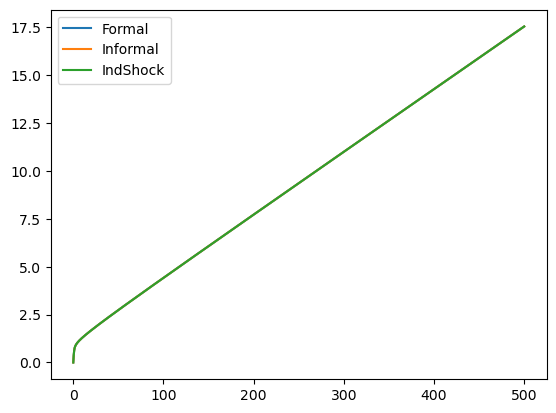

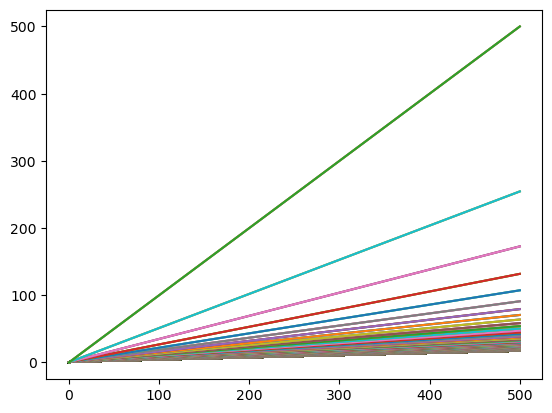

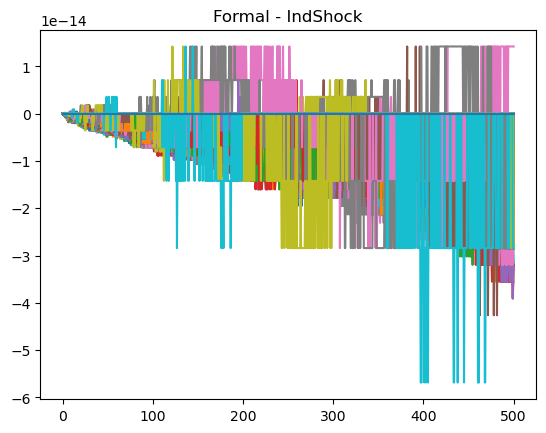

In [11]:
mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, IndShock_Example.solution[0].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

for t in range(len(TwoSectorExample.solution)):
    plt.plot(mGrid, TwoSectorExample.solution[t].cFunc[0](mGrid), label = 'Formal')
    plt.plot(mGrid, TwoSectorExample.solution[t].cFunc[1](mGrid), label = 'Informal')
    plt.plot(mGrid, IndShock_Example.solution[t].cFunc(mGrid), label = 'IndShock')
# plt.legend()
plt.show()

for t in range(len(TwoSectorExample.solution)):
    plt.plot(mGrid, TwoSectorExample.solution[t].cFunc[0](mGrid) - IndShock_Example.solution[t].cFunc(mGrid), label = 'Formal - IndShock')
    # plt.plot(mGrid, TwoSectorExample.solution[t].cFunc[1](mGrid) - IndShock_Example.solution[t].cFunc(mGrid), label = 'Informal - IndShock')
plt.title(f'Formal - IndShock')
# plt.legend()
plt.show()

# plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid) - IndShock_Example.solution[0].cFunc(mGrid), label = 'Formal')
# plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid) - IndShock_Example.solution[0].cFunc(mGrid), label = 'Informal')
# # plt.ylim(0, 1.5)
# plt.legend()
# plt.show()


# Infinite Horizon

In [12]:
cycles = 0
T_cycles = 1
HANK_Dict_inf = {
    "T_cycle": T_cycles,
    "cycles": cycles,
    # Parameters shared with the perfect foresight model
    "Rfree": [1.0 + r_ss] *T_cycles,                    # Interest factor on assets
    "LivPrb" : [LivPrb] *T_cycles,                   # Survival probability
    "DiscFac": DiscFac,

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06]*T_cycles,                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2]*T_cycles,                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    "PermGroFac": [1.01] * T_cycles,
    # HANK params
    "taxrate" : [0.0]*T_cycles, # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss]*T_cycles,
    "wage": [1.0] *T_cycles,    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : UnempPrb,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict_inf['TranShkMean_Func'] = [function] *T_cycles


In [13]:
IndShock_Inf = IndShockConsumerType(**HANK_Dict_inf)
IndShock_Inf.cycles = 0
IndShock_Inf.update()
IndShock_Inf.solve()

GPFRaw                 = 0.989653 
GPFNrm                 = 0.992854 
GPFAggLivPrb           = 0.983468 
Thorn = APF            = 0.999550 
PermGroFacAdj          = 1.006745 
uInvEpShkuInv          = 0.996777 
VAF                    = 0.960830 
WRPF                   = 0.216317 
DiscFacGPFNrmMax       = 0.984014 
DiscFacGPFAggLivPrbMax = 0.996617 


In [14]:
T_cycles = 1
init_twosector_inf = {
    "cycles" : 0,
    "T_cycle" : 1,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb, UnempPrb])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Z_ss, Z_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.01 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector_inf['TranShkMean_Func'] = [function]

In [15]:
TwoSector_Inf = TwoSectorMarkovConsumerType(**init_twosector_inf)
## RFREE WITH TIME VARYING
TwoSector_Inf.assign_parameters(
    Rfree=[np.array(2 * [1 + r_ss])] * T_cycles
)
TwoSector_Inf.update()
TwoSector_Inf.solve()

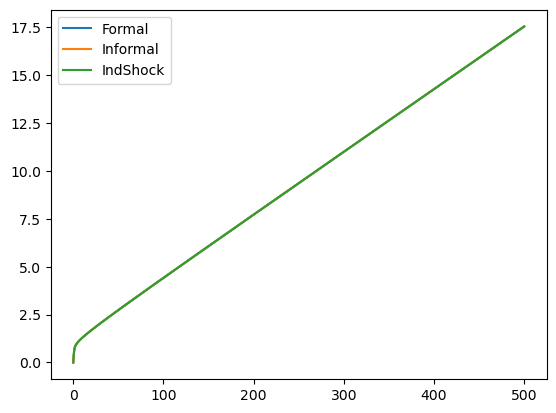

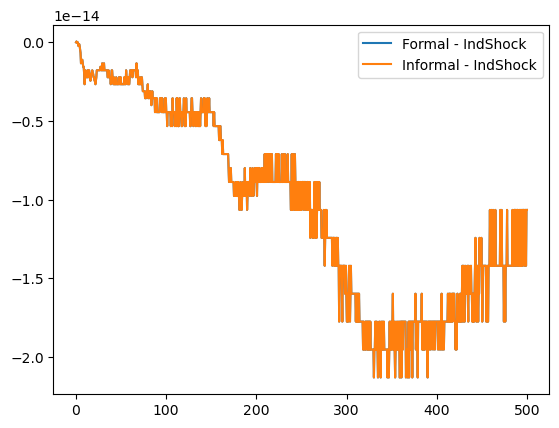

In [16]:
mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, IndShock_Inf.solution[0].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[0](mGrid) - IndShock_Inf.solution[0].cFunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[1](mGrid) - IndShock_Inf.solution[0].cFunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

# Lifecycle with shock using SS as terminal period

In [17]:
T = 300
shk_param = "Rfree"

In [18]:
# Set up finite Horizon dictionary
params = deepcopy(IndShock_Inf.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [IndShock_Inf.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [IndShock_Inf.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [IndShock_Inf.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [IndShock_Inf.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [IndShock_Inf.Rfree]
params["UnempPrb"] = params["T_cycle"] * [IndShock_Inf.UnempPrb]
params["IncUnemp"] = params["T_cycle"] * [IndShock_Inf.IncUnemp]

params['wage'] = params['T_cycle']*[IndShock_Inf.wage[0]]
params['taxrate'] = params['T_cycle']*[IndShock_Inf.taxrate[0]]
params['labor'] = params['T_cycle']*[IndShock_Inf.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[IndShock_Inf.TranShkMean_Func[0]]

# Create instance of a finite horizon agent
FinHorizonAgent_AUX_Sec1 = IndShockConsumerType(**params)
FinHorizonAgent_AUX_Sec1.cycles = 1  # required

# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent_AUX_Sec1.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent_AUX_Sec1.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent_AUX_Sec1.cFunc_terminal_ = deepcopy(IndShock_Inf.solution[0].cFunc)

dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent_AUX_Sec1.IncShkDstn = params["T_cycle"] * [IndShock_Inf.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent_AUX_Sec1.del_from_time_inv(shk_param)
FinHorizonAgent_AUX_Sec1.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(IndShock_Inf, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(IndShock_Inf, shk_param)[0]]
        + [getattr(IndShock_Inf, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(IndShock_Inf, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(IndShock_Inf, shk_param)]
        + [getattr(IndShock_Inf, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(IndShock_Inf, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent_AUX_Sec1, shk_param, peturbed_list)

# Update income process if perturbed parameter enters the income shock distribution
FinHorizonAgent_AUX_Sec1.update_income_process()

# Solve
FinHorizonAgent_AUX_Sec1.solve()

#FinHorizonAgent.Rfree = params["T_cycle"] * [Agent_GE.Rfree]
# Use Harmenberg Neutral Measure
FinHorizonAgent_AUX_Sec1.neutral_measure = True
FinHorizonAgent_AUX_Sec1.update_income_process()

# Calculate Transition Matrices
FinHorizonAgent_AUX_Sec1.define_distribution_grid()
FinHorizonAgent_AUX_Sec1.calc_transition_matrix()

In [19]:
# Set up finite Horizon dictionary
params = deepcopy(TwoSector_Inf.__dict__["parameters"])
params["T_cycle"] = T  # Dimension of Jacobian Matrix
params["cycles"] = 1  # required

# Specify a dictionary of lists because problem we are solving is technically finite horizon so variables can be time varying (see section on fake news algorithm in https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434 )
params["LivPrb"] = params["T_cycle"] * [TwoSector_Inf.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [TwoSector_Inf.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [TwoSector_Inf.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [TwoSector_Inf.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [TwoSector_Inf.Rfree[0]]
params["UnempPrb"] = params["T_cycle"] * [TwoSector_Inf.UnempPrb[0]]
params["IncUnemp"] = params["T_cycle"] * [TwoSector_Inf.IncUnemp[0]]

params['wage'] = params['T_cycle']*[TwoSector_Inf.wage[0]]
params['taxrate'] = params['T_cycle']*[TwoSector_Inf.taxrate[0]]
params['labor'] = params['T_cycle']*[TwoSector_Inf.labor[0]]
params['TranShkMean_Func'] = params['T_cycle']*[TwoSector_Inf.TranShkMean_Func[0]]

params["MrkvArray"] = params["T_cycle"] * [TwoSector_Inf.MrkvArray[0]]


In [20]:
FinHorizonAgent = TwoSectorMarkovConsumerType(**params)
# delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.del_from_time_inv("Rfree")
# Add Rfree to time varying list to be able to introduce time varying interest rates
FinHorizonAgent.add_to_time_vary("Rfree")

# Set Terminal Solution as Steady State Consumption Function
# FinHorizonAgent.solution_terminal = deepcopy(TwoSector_Inf.solution[0])
# FinHorizonAgent.cFunc_terminal_ = deepcopy(TwoSector_Inf.solution[0].cFunc)
# FinHorizonAgent.solution_terminal.cFunc = deepcopy(TwoSector_Inf.solution[0].cFunc)

FinHorizonAgent.update_solution_terminal()
# FinHorizonAgent.solution_terminal = deepcopy(TwoSectorExample.solution_terminal)
FinHorizonAgent.solution_terminal.cFunc = deepcopy(TwoSector_Inf.solution[0].cFunc)
FinHorizonAgent.solution_terminal.vPfunc = deepcopy(TwoSector_Inf.solution[0].vPfunc)

# FinHorizonAgent.solution_terminal.hNrm = np.array([0.0, 0.0])
# FinHorizonAgent.solution_terminal.MPCmin = np.array([0.0, 0.0])
# FinHorizonAgent.solution_terminal.MPCmax = np.array([1.0, 1.0])

dx = 0.0001  # Size of perturbation
# Period in which the change in the interest rate occurs (second to last period)
i = params["T_cycle"] - 1

FinHorizonAgent.IncShkDstn = params["T_cycle"] * [TwoSector_Inf.IncShkDstn[0]]

# If parameter is in time invariant list then add it to time vary list
FinHorizonAgent.del_from_time_inv(shk_param)
FinHorizonAgent.add_to_time_vary(shk_param)

# this condition is because some attributes are specified as lists while other as floats
if type(getattr(TwoSector_Inf, shk_param)) == list:
    peturbed_list = (
        (i) * [getattr(TwoSector_Inf, shk_param)[0]]
        + [getattr(TwoSector_Inf, shk_param)[0] + dx]
        + (params["T_cycle"] - i - 1) * [getattr(TwoSector_Inf, shk_param)[0]]
    )  # Sequence of interest rates the agent faces
else:
    peturbed_list = (
        (i) * [getattr(TwoSector_Inf, shk_param)]
        + [getattr(TwoSector_Inf, shk_param) + dx]
        + (params["T_cycle"] - i - 1) * [getattr(TwoSector_Inf, shk_param)]
    )  # Sequence of interest rates the agent 
    
setattr(FinHorizonAgent, shk_param, peturbed_list)

In [21]:
FinHorizonAgent.update_income_process_Markov()


In [22]:
FinHorizonAgent.solve()

In [23]:
#FinHorizonAgent.Rfree = params["T_cycle"] * [Agent_GE.Rfree]
# Use Harmenberg Neutral Measure
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process_Markov()

# Calculate Transition Matrices
FinHorizonAgent.define_distribution_grid()
# FinHorizonAgent.calc_transition_matrix()

# Compare

IndShock:
- IndShock_Inf
- FinHorizonAgent_AUX_Sec1

Markov:
- TwoSector_Inf
- FinHorizonAgent

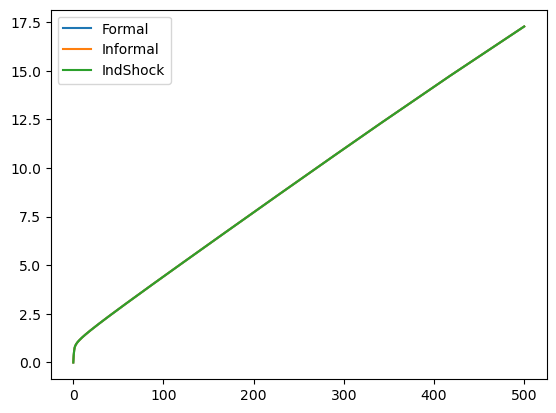

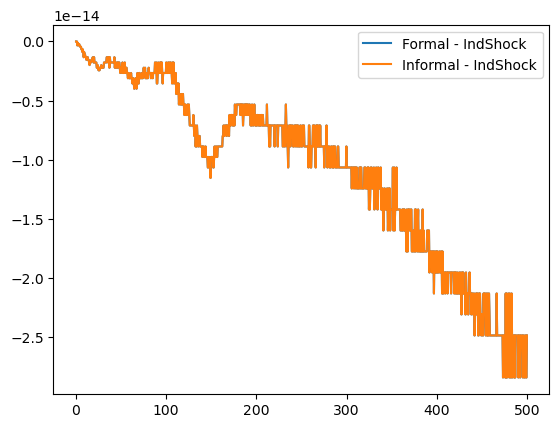

In [24]:
t = 280

mGrid = np.linspace(0, 500, 1000)
plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[0](mGrid) - FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[1](mGrid) - FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

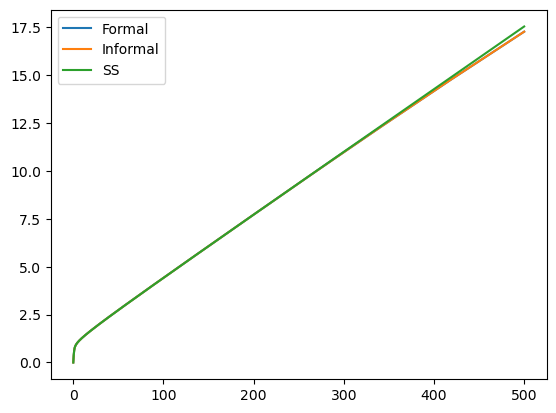

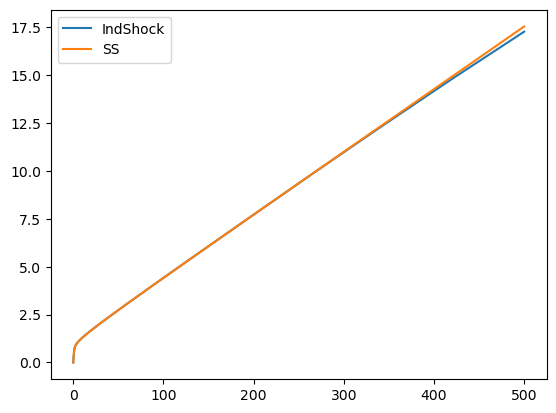

In [25]:
plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, TwoSector_Inf.solution[0].cFunc[1](mGrid), label = 'SS')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid), label = 'IndShock')
plt.plot(mGrid, IndShock_Inf.solution[0].cFunc(mGrid), label = 'SS')
plt.legend()
plt.show()

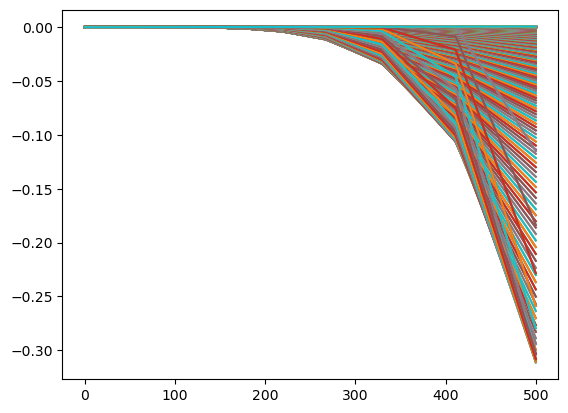

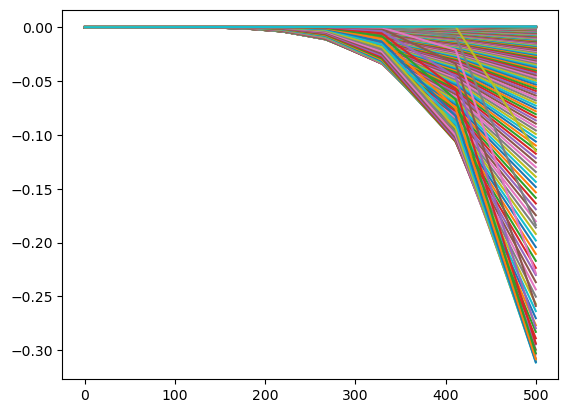

In [26]:
for t in range(len(FinHorizonAgent.solution)-1):
    plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[0](mGrid) - TwoSector_Inf.solution[0].cFunc[0](mGrid), label = 'Formal - SS')
    plt.plot(mGrid, FinHorizonAgent.solution[t].cFunc[1](mGrid) - TwoSector_Inf.solution[0].cFunc[1](mGrid), label = 'Informal - SS')
# plt.ylim(0, 1.5)
plt.show()

for t in range(len(FinHorizonAgent.solution)-1):
    plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[t].cFunc(mGrid) - IndShock_Inf.solution[0].cFunc(mGrid), label = 'IndShock - SS')
# plt.ylim(0, 1.5)
plt.show()

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\rewards.py:66: RuntimeWarning: divide by zero encountered in power
  return c**-rho


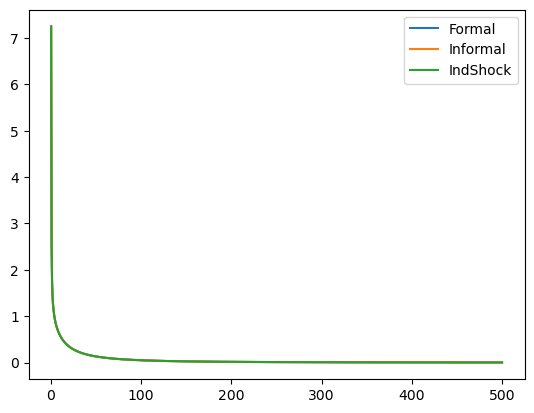

C:\Users\adria\AppData\Local\Temp\ipykernel_12224\710515814.py:9: RuntimeWarning: invalid value encountered in subtract
  plt.plot(mGrid, FinHorizonAgent.solution[-1].vPfunc[0](mGrid) - FinHorizonAgent_AUX_Sec1.solution[-1].vPfunc(mGrid), label = 'Formal - IndShock')
C:\Users\adria\AppData\Local\Temp\ipykernel_12224\710515814.py:10: RuntimeWarning: invalid value encountered in subtract
  plt.plot(mGrid, FinHorizonAgent.solution[-1].vPfunc[1](mGrid) - FinHorizonAgent_AUX_Sec1.solution[-1].vPfunc(mGrid), label = 'Informal - IndShock')


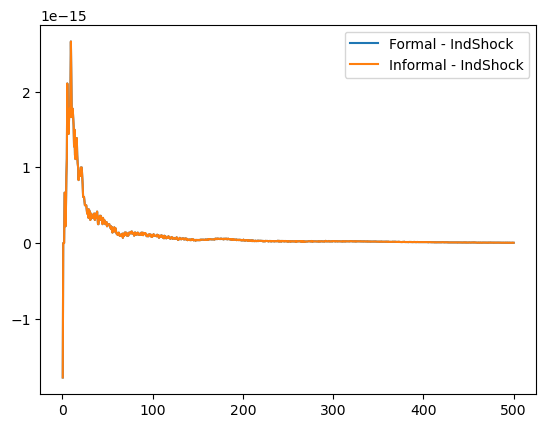

In [27]:
### vPFUnc in last period
plt.plot(mGrid, FinHorizonAgent.solution[-1].vPfunc[0](mGrid), label = 'Formal')
plt.plot(mGrid, FinHorizonAgent.solution[-1].vPfunc[1](mGrid), label = 'Informal')
plt.plot(mGrid, FinHorizonAgent_AUX_Sec1.solution[-1].vPfunc(mGrid), label = 'IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

plt.plot(mGrid, FinHorizonAgent.solution[-1].vPfunc[0](mGrid) - FinHorizonAgent_AUX_Sec1.solution[-1].vPfunc(mGrid), label = 'Formal - IndShock')
plt.plot(mGrid, FinHorizonAgent.solution[-1].vPfunc[1](mGrid) - FinHorizonAgent_AUX_Sec1.solution[-1].vPfunc(mGrid), label = 'Informal - IndShock')
# plt.ylim(0, 1.5)
plt.legend()
plt.show()

In [28]:
### Indshock
vars(FinHorizonAgent_AUX_Sec1.solution_terminal)

{'cFunc': <HARK.interpolation.LinearInterp at 0x159f7200b20>,
 'vFunc': <HARK.interpolation.ValueFuncCRRA at 0x159f1e00f70>,
 'vPfunc': <HARK.interpolation.MargValueFuncCRRA at 0x159f21d8ac0>,
 'vPPfunc': <HARK.interpolation.MargMargValueFuncCRRA at 0x159f1fb86a0>,
 'mNrmMin': 0.0,
 'hNrm': 0.0,
 'MPCmin': 1.0,
 'MPCmax': 1.0}

In [29]:
### Markov
vars(FinHorizonAgent.solution_terminal)

{'cFunc': [<HARK.interpolation.LowerEnvelope at 0x159f714a9a0>,
 'vFunc': [<HARK.interpolation.ValueFuncCRRA at 0x159f71ee250>,
 'vPfunc': [<HARK.interpolation.MargValueFuncCRRA at 0x159f73ef5e0>,
 'vPPfunc': [<HARK.interpolation.MargMargValueFuncCRRA at 0x159f7a2a5b0>,
 'mNrmMin': array([0., 0.]),
 'hNrm': 0.0,
 'MPCmin': array([1., 1.]),
 'MPCmax': array([1., 1.]),
 'hRto': array([0., 0.])}

### Calc Jacobians with TransitionMatrices from IndShockConsumer

In [30]:
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process_Markov()

# Calculate Transition Matrices
FinHorizonAgent.define_distribution_grid()
FinHorizonAgent.calc_transition_matrix_Markov()

In [31]:
dist_mGrid = FinHorizonAgent.dist_mGrid

In [32]:
TwoSector_Inf.compute_steady_state()

(1.2222238166427952, 0.8163455887194062)

In [33]:
# # Use Harmenberg Neutral Measure
# TwoSector_Inf.neutral_measure = True
# TwoSector_Inf.update_income_process_Markov()

In [34]:
## Compare Steady State Transition Matrices
IndShock_Inf.compute_steady_state()

GPFRaw                 = 0.989653 
GPFNrm                 = 0.992854 
GPFAggLivPrb           = 0.983468 
Thorn = APF            = 0.999550 
PermGroFacAdj          = 1.006745 
uInvEpShkuInv          = 0.996777 
VAF                    = 0.960830 
WRPF                   = 0.216317 
DiscFacGPFNrmMax       = 0.984014 
DiscFacGPFAggLivPrbMax = 0.996617 


(1.2222238166427914, 0.8163455887194055)

In [35]:
TranMatrix_aux = []
TranMatrix_shape = (len(dist_mGrid) * 2, len(dist_mGrid) * 2)
for i in range(T):
    ### Ignore transition between Markov states and constrauct a 400 x 400 matrix
    TranMatrix_aux_array = np.zeros(TranMatrix_shape)
    TranMatrix_Sec1 = FinHorizonAgent_AUX_Sec1.tran_matrix[i]
    TranMatrix_Sec2 = FinHorizonAgent_AUX_Sec1.tran_matrix[i]
    
    # Fill the upper left corner of TranMatrix
    TranMatrix_aux_array[:len(dist_mGrid), :len(dist_mGrid)] = TranMatrix_Sec1 * MrkvArray[0, 0] # Start Markov State 1 End in Markov State 1

    # Fill the upper right corner of TranMatrix
    TranMatrix_aux_array[:len(dist_mGrid), len(dist_mGrid):] = TranMatrix_Sec1 * MrkvArray[0, 1] # Start Markov State 1 End in Markov State 2

    # Fill the lower left corner of TranMatrix
    TranMatrix_aux_array[len(dist_mGrid):, :len(dist_mGrid)] = TranMatrix_Sec2 * MrkvArray[1, 0] # Start Markov State 2 End in Markov State 1

    # Fill the lower right corner of TranMatrix
    TranMatrix_aux_array[len(dist_mGrid):, len(dist_mGrid):] = TranMatrix_Sec2 * MrkvArray[1, 1] # Start Markov State 2 End in Markov State 2

    TranMatrix_aux.append(TranMatrix_aux_array)

In [36]:
### Ignore transition between Markov states and constrauct a 400 x 400 matrix
TranMatrix_IndShock_SS = np.zeros(TranMatrix_shape)
TranMatrix_Sec1 = IndShock_Inf.tran_matrix
TranMatrix_Sec2 = IndShock_Inf.tran_matrix

# Fill the upper left corner of TranMatrix
TranMatrix_IndShock_SS[:len(dist_mGrid), :len(dist_mGrid)] = TranMatrix_Sec1 * MrkvArray[0, 0] # Start Markov State 1 End in Markov State 1

# Fill the upper right corner of TranMatrix
TranMatrix_IndShock_SS[:len(dist_mGrid), len(dist_mGrid):] = TranMatrix_Sec1 * MrkvArray[0, 1] # Start Markov State 1 End in Markov State 2

# Fill the lower left corner of TranMatrix
TranMatrix_IndShock_SS[len(dist_mGrid):, :len(dist_mGrid)] = TranMatrix_Sec2 * MrkvArray[1, 0] # Start Markov State 2 End in Markov State 1

# Fill the lower right corner of TranMatrix
TranMatrix_IndShock_SS[len(dist_mGrid):, len(dist_mGrid):] = TranMatrix_Sec2 * MrkvArray[1, 1] # Start Markov State 2 End in Markov State 2


### Compare them

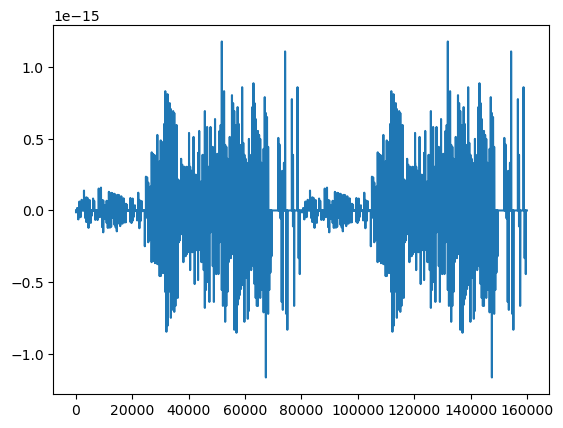

In [37]:
plt.plot(TranMatrix_IndShock_SS.flatten() - TwoSector_Inf.tran_matrix.flatten()) 

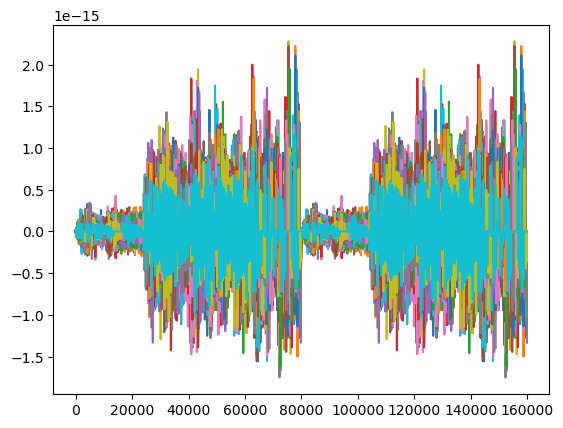

In [38]:
for t in range(T):
    plt.plot(TranMatrix_aux[t].flatten() - FinHorizonAgent.tran_matrix[t].flatten())

In [ ]:
stop

### Calc Jacobians using SS TranMatrix from IndShock

In [39]:
##########
# STEP 1 # of fake news algorithm, As in the paper for Curly Y and Curly D. Here the policies are over assets and consumption so we denote them as curly C and curly D.
##########
# Policy Functions are now arrays with dimension (Nr of States x len(dist_mGrid)). We need to stack them to get a vector.
a_ss = TwoSector_Inf.aPol_Grid.flatten()  # steady state Asset Policy
c_ss = TwoSector_Inf.cPol_Grid.flatten()  # steady state Consumption Policy
# tranmat_ss = TwoSector_Inf.tran_matrix  # Steady State Transition Matrix
tranmat_ss = TranMatrix_IndShock_SS ## CHANGED

# List of asset policies grids where households expect the shock to occur in the second to last Period
## Need to concatenate for each T
a_t = []
for t in range(T):
    a_t.append(FinHorizonAgent.aPol_Grid[t].flatten())
# add steady state assets to list as it does not get appended in calc_transition_matrix method
a_t.append(TwoSector_Inf.a_ss)

# List of consumption policies grids where households expect the shock to occur in the second to last Period
# c_t = [np.concatenate(FinHorizonAgent.cPol_Grid)]
c_t = []
for t in range(T):
    c_t.append(FinHorizonAgent.cPol_Grid[t].flatten())
# add steady state consumption to list as it does not get appended in calc_transition_matrix method
c_t.append(TwoSector_Inf.c_ss)

da0_s = []  # Deviation of asset policy from steady state policy
dc0_s = []  # Deviation of Consumption policy from steady state policy
for i in range(T):
    da0_s.append(a_t[T - i] - a_ss)
    dc0_s.append(c_t[T - i] - c_ss)

da0_s = np.array(da0_s)
dc0_s = np.array(dc0_s)


In [40]:
# Steady state distribution of market resources (permanent income weighted distribution)
D_ss = TwoSector_Inf.vec_erg_dstn.T[0] ### NOT CHANGED
dA0_s = []
dC0_s = []
for i in range(T):
    dA0_s.append(np.dot(da0_s[i], D_ss))
    dC0_s.append(np.dot(dc0_s[i], D_ss))

dA0_s = np.array(dA0_s)


In [41]:
# This is equivalent to the curly Y scalar detailed in the first step of the algorithm
A_curl_s = dA0_s / dx

dC0_s = np.array(dC0_s)
C_curl_s = dC0_s / dx

# List of computed transition matrices for each period
tranmat_t = FinHorizonAgent.tran_matrix
tranmat_t.append(tranmat_ss)

# List of change in transition matrix relative to the steady state transition matrix
dlambda0_s = []
for i in range(T):
    dlambda0_s.append(tranmat_t[T  -   i] - tranmat_ss)

dlambda0_s = np.array(dlambda0_s)



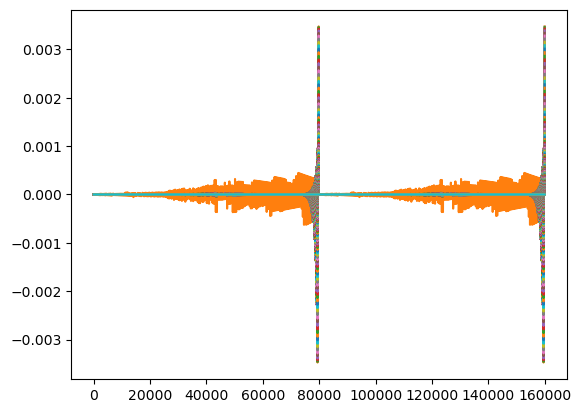

In [42]:
for i in range(T):
    plt.plot(dlambda0_s[i].flatten())
plt.show()
# dlambda0_s


In [43]:
dD0_s = []
for i in range(T):
    dD0_s.append(np.dot(dlambda0_s[i], D_ss))

dD0_s = np.array(dD0_s)
D_curl_s = dD0_s / dx  # Curly D in the sequence space jacobian


In [44]:
########
# STEP2 # of fake news algorithm
########

# Expectation Vectors
exp_vecs_a = []
exp_vecs_c = []

# First expectation vector is the steady state policy
exp_vec_a = a_ss
exp_vec_c = c_ss
for i in range(T):
    exp_vecs_a.append(exp_vec_a)
    exp_vec_a = np.dot(tranmat_ss.T, exp_vec_a)

    exp_vecs_c.append(exp_vec_c)
    exp_vec_c = np.dot(tranmat_ss.T, exp_vec_c)

# for i in range(T):
#     exp_vecs_a.append(exp_vec_a)
#     exp_vec_a = np.dot(tranmat_ss, exp_vec_a)

#     exp_vecs_c.append(exp_vec_c)
#     exp_vec_c = np.dot(tranmat_ss.T, exp_vec_c)

# for i in range(T):
#     exp_vecs_a.append(exp_vec_a)
#     exp_vec_a = np.dot(exp_vec_a, tranmat_ss )

#     exp_vecs_c.append(exp_vec_c)
#     exp_vec_c = np.dot(exp_vec_c, tranmat_ss)

# Turn expectation vectors into arrays
exp_vecs_a = np.array(exp_vecs_a)
exp_vecs_c = np.array(exp_vecs_c)


In [45]:
#########
# STEP3 # of the algorithm. In particular equation 26 of the published paper.
#########
# Fake news matrices
Curl_F_A = np.zeros((T, T))  # Fake news matrix for assets
Curl_F_C = np.zeros((T, T))  # Fake news matrix for consumption

# First row of Fake News Matrix
Curl_F_A[0] = A_curl_s
Curl_F_C[0] = C_curl_s


for i in range(T - 1):
    for j in range(T):
        Curl_F_A[i + 1][j] = np.dot(exp_vecs_a[i], D_curl_s[j])
        Curl_F_C[i + 1][j] = np.dot(exp_vecs_c[i], D_curl_s[j])


In [46]:
D_curl_s

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.07988407e-08, -3.11241342e-07, -6.08269387e-07, ...,
        -2.27486655e-17, -3.94287409e-17, -3.28038680e-16],
       [ 6.95689030e-09,  4.23800324e-08,  8.30192888e-08, ...,
         2.40094855e-16,  3.95574864e-16, -6.30047439e-16],
       ...,
       [-8.67783825e-20,  1.42647543e-20,  0.00000000e+00, ...,
        -2.84335253e-21, -8.62597578e-21, -8.56943164e-20],
       [-8.67783825e-20,  1.42647543e-20,  0.00000000e+00, ...,
        -2.36223756e-21, -8.25348134e-21, -8.83471702e-20],
       [-8.67783825e-20,  1.42647543e-20,  0.00000000e+00, ...,
        -1.90519230e-21, -7.90301748e-21, -9.08963556e-20]])

In [47]:
########
# STEP4 #  of the algorithm
########

# Function to compute jacobian matrix from fake news matrix
def J_from_F(F):
    J = F.copy()
    for t in range(1, F.shape[0]):
        J[1:, t] += J[:-1, t-1]
    return J

J_A = J_from_F(Curl_F_A)
J_C = J_from_F(Curl_F_C)


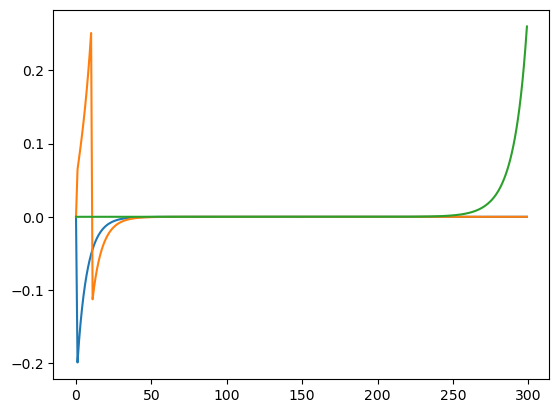

In [48]:
plt.plot(J_C[0])
plt.plot(J_C[10])
plt.plot(J_C[-1])

### Step by Step Transition Matrix SS

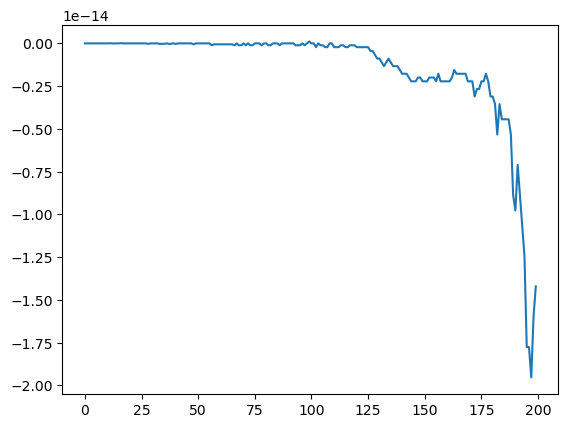

In [49]:
plt.plot(TwoSector_Inf.cPol_Grid[0] - IndShock_Inf.cPol_Grid)

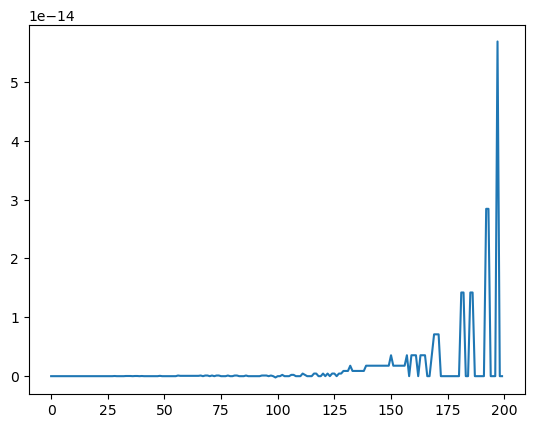

In [50]:
plt.plot(TwoSector_Inf.aPol_Grid[0] - IndShock_Inf.aPol_Grid)

In [51]:
shk_dstn = TwoSector_Inf.IncShkDstn

In [52]:
MrkvPrbs = TwoSector_Inf.MrkvArray[0]
MrkvPrbsInit = TwoSector_Inf.MrkvPrbsInit
LivPrb = TwoSector_Inf.LivPrb[0]

In [53]:
TwoSector_Inf.neutral_measure

True

In [54]:
shk_dstn

[[<TwoSectorModel_HANK.HANKIncShkDstn at 0x159f7103fd0>,

In [55]:
# Loop over Markov States
PolGridShape = (len(MrkvPrbsInit), len(dist_mGrid))  # Shape of policy grids
bNext = np.zeros(PolGridShape)  # Array of bank balance grids for each period in T_cycle


In [56]:
# Variables which change by Markov State
ShockShape = (len(MrkvPrbsInit), len(shk_dstn[0][0].pmv))
shk_prbs = np.zeros(ShockShape)  # Array of shock probabilities for each Markov state
tran_shks = np.zeros(ShockShape)  # Array of transitory shocks for each Markov state
perm_shks = np.zeros(ShockShape)  # Array of permanent shocks for each Markov state

In [57]:
### Take aPolGrid from IndShock
aPol_Grid_aux = np.zeros_like(TwoSector_Inf.aPol_Grid)
aPol_Grid_aux[0] = IndShock_Inf.aPol_Grid
aPol_Grid_aux[1] = IndShock_Inf.aPol_Grid

In [58]:
for i in range(len(MrkvPrbsInit)):
    if type(TwoSector_Inf.Rfree) == list:
        bNext[i] = TwoSector_Inf.Rfree[0][i] * aPol_Grid_aux[i]
    else:
        bNext[i] = TwoSector_Inf.Rfree[i] * aPol_Grid_aux[i]



In [59]:
### IncShkDstn is DIFFERENT!!!!!

In [60]:
for i in range(len(MrkvPrbsInit)):
    # Obtain shocks and shock probabilities from income distribution this period
    shk_prbs[i] = shk_dstn[0][i].pmv   # Probability of shocks this period
    # Transitory shocks this period
    tran_shks[i] = shk_dstn[0][i].atoms[1]
    # Permanent shocks this period
    perm_shks[i] = shk_dstn[0][i].atoms[0]

In [61]:
shk_dstn_IndShock = IndShock_Inf.IncShkDstn

shk_prbs_IndShock = np.zeros(ShockShape)  # Array of shock probabilities for each Markov state
tran_shks_IndShock = np.zeros(ShockShape)  # Array of transitory shocks for each Markov state
perm_shks_IndShock = np.zeros(ShockShape)  # Array of permanent shocks for each Markov state

In [62]:
for i in range(len(MrkvPrbsInit)):
    # # Obtain shocks and shock probabilities from income distribution this period
    # shk_prbs[i] = shk_dstn[0][i].pmv   # Probability of shocks this period
    # # Transitory shocks this period
    # tran_shks[i] = shk_dstn[0][i].atoms[1]
    # # Permanent shocks this period
    # perm_shks[i] = shk_dstn[0][i].atoms[0]

    ### Take IndShock Ones
    shk_prbs_IndShock[i] = shk_dstn_IndShock[0].pmv
    tran_shks_IndShock[i] = shk_dstn_IndShock[0].atoms[1]
    # Permanent shocks this period
    perm_shks_IndShock[i] = shk_dstn_IndShock[0].atoms[0]

In [63]:
shk_prbs - shk_prbs_IndShock

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [64]:
tran_shks - tran_shks_IndShock

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [65]:
perm_shks - perm_shks_IndShock

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [66]:
NewBornDist = np.zeros((len(MrkvPrbsInit), len(dist_mGrid)))  # To store modified NewBornDist arrays

# Iterate over each element in MrkvPrbsInit and modify NewBornDist
for i, prob in enumerate(MrkvPrbsInit):
    NewBornDist[i] = jump_to_grid_1D(
                        np.zeros_like(tran_shks[i]), # No shocks at the beginning. Therefore, does not matter which shocks I take
                        shk_prbs[i],
                        dist_mGrid,) #* prob



In [67]:
NewBornDist

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [68]:
# Compute Transition Matrix given shocks and grids.
TranMatrix_M = gen_tran_matrix_1D_Markov(
    dist_mGrid,
    MrkvPrbs,
    bNext,
    shk_prbs,
    perm_shks,
    tran_shks,
    LivPrb,
    NewBornDist,
)

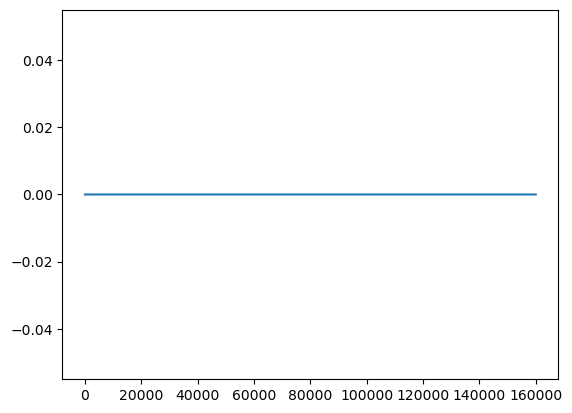

In [69]:
plt.plot(TranMatrix_IndShock_SS.flatten() - TranMatrix_M.flatten()) 

In [70]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Use Harmenberg Neutral Measure
TwoSector_Inf.neutral_measure = True
TwoSector_Inf.update_income_process_Markov()

In [ ]:
TwoSector_Inf.IncShkDstn[0][i].pmv

array([0.00918145, 0.03488952, 0.03488952, 0.03488952, 0.03488952,
       0.03488952, 0.00966897, 0.03674209, 0.03674209, 0.03674209,
       0.03674209, 0.03674209, 0.0099824 , 0.03793311, 0.03793311,
       0.03793311, 0.03793311, 0.03793311, 0.01030625, 0.03916374,
       0.03916374, 0.03916374, 0.03916374, 0.03916374, 0.01086093,
       0.04127153, 0.04127153, 0.04127153, 0.04127153, 0.04127153])

In [ ]:


# LivPrb = []            

for i in range(len(MrkvPrbsInit)):
    self.cPol_Grid[i] = self.solution[0].cFunc[i](dist_mGrid)
    self.aPol_Grid[i] = dist_mGrid - self.cPol_Grid[i]  # Asset policy grid in period k
            
    if type(self.Rfree) == list:
        bNext[i] = self.Rfree[0][i] * self.aPol_Grid[i]
    else:
        bNext[i] = self.Rfree[i] * self.aPol_Grid[i]


    # Obtain shocks and shock probabilities from income distribution this period
    shk_prbs[i] = shk_dstn[0][i].pmv   # Probability of shocks this period
    # Transitory shocks this period
    tran_shks[i] = shk_dstn[0][i].atoms[1]
    # Permanent shocks this period
    perm_shks[i] = shk_dstn[0][i].atoms[0]

    # # Update probability of staying alive this period
    # LivPrb.append(self.LivPrb[0][i])

if len(dist_pGrid) == 1:
    # New borns have this distribution (assumes start with no assets and permanent income=1)
    NewBornDist = np.zeros((len(MrkvPrbsInit), len(dist_mGrid)))  # To store modified NewBornDist arrays

    # Iterate over each element in MrkvPrbsInit and modify NewBornDist
    for i, prob in enumerate(MrkvPrbsInit):
        NewBornDist[i] = jump_to_grid_1D(
                            np.zeros_like(tran_shks[i]), # No shocks at the beginning. Therefore, does not matter which shocks I take
                            shk_prbs[i],
                            dist_mGrid,) #* prob

    # Compute Transition Matrix given shocks and grids.
    TranMatrix_M = gen_tran_matrix_1D_Markov(
        dist_mGrid,
        MrkvPrbs,
        bNext,
        shk_prbs,
        perm_shks,
        tran_shks,
        LivPrb,
        NewBornDist,
    )
    
    self.tran_matrix = TranMatrix_M
